In [1]:
import numpy as np
from qutip import sigmaz, mesolve, Bloch, Qobj

from util import pretty

# Adiabatic Quantum Computing

We introduce **adiabatic quantum computing** (AQC) in this notebook. AQC applies perturbations to the Hamiltonian of a quantum system to transform the quantum state by the **adiabatic theorem**. Thus, AQC is a form of analog QC which relies on a different aspect of quantum mechanics to perform QC.

## Review: Hamiltonian

As a reminder, a **Hamiltonian** for a quantum system with $n$ qubits of information can be encoded as a $2^N \times 2^N$ Hermitian matrix where $N = 2^N$ encoding the total energy of a quantum system.

In [2]:
# Example Hamiltonian
H = Qobj(np.array([
    [0, -1j],
    [1j, 0]
]), dims=[[2], [2]])
pretty(H.full())

<IPython.core.display.Latex object>

### Spectral Decomposition


By the **Spectral Decomposition**, every Hermitian matrix can be diagonalized:

$$
H = U \Lambda U^{-1}
$$

where $U$ is an orthonormal matrix of **eigenvectors** and $\Lambda$ is a diagonal matrix containing the **eigenvalues**. Recall that $U^{-1} = U^*$ when $U$ is orthonormal.

In [3]:
# Eigenvector/eigenvalue decompostion
eigenvalues, eigenvectors = np.linalg.eigh(H.full())
print("Eigenvalues", eigenvalues)
print("Eigenvectors")
pretty(eigenvectors)

Eigenvalues [-1.  1.]
Eigenvectors


<IPython.core.display.Latex object>

In [4]:
H_reconstructed = eigenvectors @ np.diag(eigenvalues) @ np.conjugate(eigenvectors).T
np.allclose(H.full(), H_reconstructed)

True

### Ground State and Energy

1. The eigenvalues of a Hamiltonian can be interpreted as energies. Recall that a Hermitian matrix has real eigenvalues so that energies are real numbers. The smallest eigenvalue is called the **ground energy**.
2. The eigenvector associated with the smallest eigenvalue of a Hamiltonian can be interpreted as a **ground state**.

In [5]:
print("All real eigenvalues", [np.allclose(ev.imag, 0j) for ev in eigenvalues])
print("Ground energy", eigenvalues[0])
print("Ground state")
pretty(eigenvectors[0])

All real eigenvalues [True, True]
Ground energy -1.0
Ground state


<IPython.core.display.Latex object>

In [6]:
print("Ground energy", H.groundstate()[0])
print("Ground state")
pretty(H.groundstate()[1])

Ground energy -1.0
Ground state


<IPython.core.display.Latex object>

## Adiabatic Evolution

AQC relies on the **adiabatic theorem** to perform computation. Given a time-dependent Hamiltonian $H_t$ on a time interval $[0, T]$ that meets certain conditions, the quantum state of a quantum system under adiabatic evolution will transition from the ground state of $H_0$ to the ground state of $H_T$. That is,

$$
\text{GroundState}(H_0) \rightarrow_T \text{GroundState}(H_T)
$$

if $H_t$ satisfies certain conditions given by the adiabatic theorem. Thus, we require several ingredients to perform AQC:
1. a time-varying Hamiltonian $H_t$ that meets the conditions of the adiabatic theorem and
2. a method to compute the time $T$ that also meets the conditions of the adiabatic theorem.

We'll discuss this in turn.

### Time-Varying Hamiltonian

A commonly-used time-dependent Hamiltonian for AQC is

$$
H_t = \left(1 - \frac{t}{T} \right ) H_0 + \frac{t}{T} H_T
$$

which linearly interpolates between $H_0$ and $H_T$. This meets one of the conditions of an adiabatic theorem which requires that $H_t$ be "smooth" in $t$. We'll given an example now that puts $\ket{1}$ in superposition 

$$
\ket{1} \rightarrow \frac{1}{\sqrt{2}}(\ket{0} - \ket{1}) \,.
$$

In [7]:
H_0 = sigmaz()
pretty(H_0.full())

<IPython.core.display.Latex object>

In [8]:
# Initial state is |1>
global_phase = np.exp(-1j * np.pi)
pretty(global_phase * H_0.groundstate()[-1])

<IPython.core.display.Latex object>

In [9]:
# Final state is |->
H_T = Qobj(np.array([
    [0, 0.5],
    [0.5, 0]
]), dims=[[2], [2]])
pretty(global_phase * H_T.groundstate()[-1])

<IPython.core.display.Latex object>

In [10]:
def linear_interpolation(H_0, H_T, T):
    def s(t):
        return t / T
    H_t = [[H_0, lambda t: 1 - s(t)], [H_T, s]]
    return H_t

linear_interpolation(H_0, H_T, 10)

[[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
  Qobj data =
  [[ 1.  0.]
   [ 0. -1.]],
  <function __main__.linear_interpolation.<locals>.<lambda>(t)>],
 [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
  Qobj data =
  [[0.  0.5]
   [0.5 0. ]],
  <function __main__.linear_interpolation.<locals>.s(t)>]]

### Computing the Evolution Time

The time $T$ is inversely related to the **spectral gap** which is the minimum difference between the lowest and second-lowest eigenvalues of the Hamiltonian of $H_t$. Thus, the larger the spectral gap, the shorter the time $T$, and vice versa. Thus the spectral gap governs how "slowly" we must vary the Hamiltonian in order to perform adiabatic evolution. In general, we must analyze $H_t$ on a case-by-case basis to determine the best (i.e., shortest) $T$.

In [11]:
# Let's be conservative
T = 10 

### Putting it Together

Define an **adiabatic quantum program** as a tuple

$$
(H_t, T)
$$ 

where $H_t$ is a time-dependent Hamiltonian defined for $t \in [0, T]$ and such that $H_t$ has a unique ground state $\ket{\psi(t)}$ for all $0 \leq t \leq T$ where $T$ is the length of simulation. Then

$$
\text{GroundState}(H_0) \rightarrow_T \text{GroundState}(H_T)
$$

in time $T$.

In [12]:
# Adiabatic program
T = 5*np.pi
H_t = linear_interpolation(H_0, H_T, T)

In [13]:
psi_0 = global_phase * H_0.groundstate()[-1]  # Initial state
psi_T = global_phase * H_T.groundstate()[-1]  # Final state

In [14]:
# Simulation
times = np.linspace(0, T, 500)
result = mesolve(H_t, psi_0, times, [], [])
psi_T_sim = global_phase * result.states[-1]
pretty(psi_T_sim)

<IPython.core.display.Latex object>

We can plot the answer on a Bloch sphere.

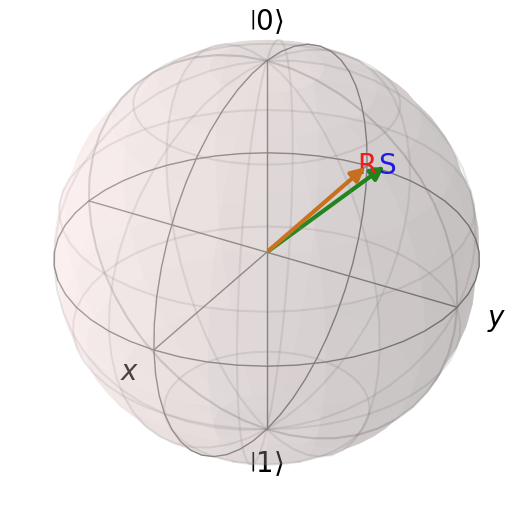

In [15]:
b = Bloch()
b.add_states(psi_T_sim)
b.add_annotation(psi_T_sim, "S", color='b')  # S for simulated
b.add_states(psi_T)
b.add_annotation(psi_T, "R", color='r')      # R for real
b.show()

We can also check the overlap.

In [16]:
overlap = abs(psi_T_sim.overlap(psi_T))**2
print(f"Overlap with ground state of final Hamiltonian: {overlap:.4f}")

Overlap with ground state of final Hamiltonian: 0.9963


### Shorter Time

If we try to run for too short of a time, we risk perturbing the Hamiltonian at too fast a rate. Therefore, our computation will not produce the desired effect.

Overlap with ground state of final Hamiltonian: 0.7696


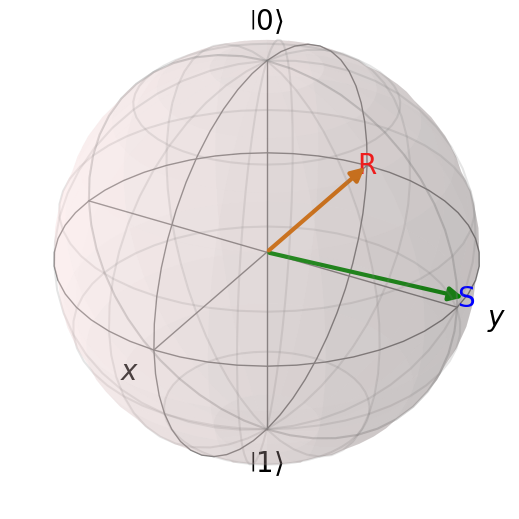

In [17]:
# Adiabatic program
T = np.pi
H_t = linear_interpolation(H_0, H_T, T)

# Simulation
times = np.linspace(0, T, 500)
result = mesolve(H_t, psi_0, times, [], [])
psi_T_sim = result.states[-1]

overlap = abs(psi_T_sim.overlap(psi_T))**2
print(f"Overlap with ground state of final Hamiltonian: {overlap:.4f}")

b = Bloch()
b.add_states(psi_T_sim)
b.add_annotation(psi_T_sim, "S", color='b')  # S for simulated
b.add_states(psi_T)
b.add_annotation(psi_T, "R", color='r')      # R for real
b.show()

## Summary

1. We have reviewed the ground state and ground energy of a Hamiltonian.
2. We have seen how AQC performs computation by transitioning from the ground state of an initial Hamiltonian to the ground state of a final hamiltonian by perturbing a Hamiltonian over time.
3. The time that we run an adiabatic computation affects the fidelty of our result.

## References

[1] [On the Adiabatic Theorem of Quantum Mechanics](https://journals.jps.jp/doi/abs/10.1143/JPSJ.5.435?journalCode=jpsj)

[2] [Adiabatic Quantum Computation is Equivalent to Standard Quantum Computation](https://arxiv.org/pdf/quant-ph/0405098)

[3] [The quantum adiabatic optimization algorithm and local minima](https://dl.acm.org/doi/10.1145/1007352.1007428)

[4] [Lecture 18: The quantum adiabatic theorem by Prof. Andrew Childs](https://www.cs.umd.edu/~amchilds/teaching/w08/l18.pdf)

## Appendix: Adiabatic Theorem 

### Preliminaries

Define $\Delta(H)$ to be the **spectral gap** of a Hamiltonian H, to be the difference between the lowest eigenvalue of H and its second lowest eigenvalue.

In [18]:
def spectral_gap(H: np.ndarray) -> float:
    eigvals, _ = np.linalg.eigh(H.full())
    idxs = np.argsort(eigvals)
    for idx in idxs[1:]:
        if eigvals[idx] > eigvals[0]:
            return eigvals[idx] - eigvals[0]
    return 0

spectral_gap(H_0), spectral_gap(H_T)

(np.float64(2.0), np.float64(1.0))

Define the **spectral norm**

$$
\| H \| := \max_w \frac{\| Hw \|}{\| w \|}.
$$


In [19]:
print("||H_0||", np.linalg.norm(H_0.full(), ord=2))
print("||H_T||", np.linalg.norm(H_T.full(), ord=2))

||H_0|| 1.0
||H_T|| 0.5


### Adiabatic Theorem (Theorem 2.1 [2] and [3])

Let $H_{\text{init}}$ and $H_{\text{final}}$ be two Hamiltonians acting on a quantum system. Define

$$
H(s) := (1 - s)H_{\text{init}} + sH_{\text{final}}
$$

and assume that $H(s)$ has a unique ground state for all $s$.

Then for any fixed $\delta > 0$, if

$$
T \geq \Omega \left( \frac{\| H_{\text{final}} - H_{\text{init}} \|^{1+\delta}}{\epsilon^{\delta} \min_{s \in [0,1]} \{ \Delta^{2+\delta}(H(s)) \}} \right)
$$

then the final state of an adiabatic evolution according to $H$ for time $T$ (with an appropriate setting of global phase) is $\epsilon$-close in $\ell_2$-norm to the ground state of $H_{\text{final}}$. 